# Integrative analysis of pathway deregulation in obesity #

## Python implementation

### Batch Effect Evaluation

1. We have to integrate all the 4 output of the pre-processing step on the previous 4 batches;
2. Perform a PCA evaluation and see that samples can be defined alog components that can be considered as the belonging to each batch;
3. Perform a SVD approach to eliminate batch effect;
4. Perform again PCA and show that the samples can be described using only 2 principal component that should be being lean or obese

### Imports

In [1]:
# Import std libraries
import os
from operator import itemgetter 
import re

# Import third party
import numpy as np
import scipy as sp
from numpy import *
import pandas as pd
import GEOparse
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

# import plotting tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

# Set logging
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logging.getLogger("GEOparse").setLevel(logging.WARNING)

plot_dir_path = './plots/'
if not os.path.exists(plot_dir_path):
    os.makedirs(plot_dir_path)
    print('created ./path directory')
    
# enable matplotlib inline
%matplotlib inline

### Load Datasets

Dataset are loaded from .pkl file created in a previous step of the pre-processing phase.

In the .pkl file there will be and index (GENE_ENTREZ_ID) and the sample taken into accout in the dataset

In [2]:
suffix = "_table.pkl"
list_of_dataset_to_load = ['GSE56649', 'GSE15573', 'GSE19821', 'GSE4588']
batches_df = []
person_batch_index = []
for i, batch_name in enumerate(list_of_dataset_to_load):
    # read the batch
    current_df = pd.read_pickle('./data/' + batch_name + suffix)
    current_shape = current_df.shape
    
    # plot stuff
    person_batch_index += [(i)]*current_shape[1]
    
    # logs
    print(batch_name, current_shape, 'is index unique? ->', current_df.index.is_unique)
    
    # append to batches_df list
    batches_df.append(current_df)

# concat together the dataframes
merged_df = pd.concat(batches_df, axis='columns')

# drop any missing rows because of the concatenation
merged_df = merged_df.dropna(axis='rows', how='any')

# preview
print(merged_df.shape)
merged_df.head()

GSE56649 (20486, 22) is index unique? -> True
GSE15573 (24547, 33) is index unique? -> True
GSE19821 (11479, 15) is index unique? -> True
GSE4588 (20483, 34) is index unique? -> True
(10426, 104)


,GSM1366352_UD,GSM1366356_UD,GSM1366354_UD,GSM1366358_UD,GSM1366360_UD,GSM1366366_UN,GSM1366351_UD,GSM1366367_UN,GSM1366369_UN,GSM1366362_UN,...,GSM101872_UN,GSM102706_UD,GSM101877_UN,GSM101885_UD,GSM101882_UD,GSM101966_UN,GSM102709_UD,GSM101964_UN,GSM101970_UN,GSM102704_UD
10,-20.887740,-21.518597,-21.062867,-19.145017,-20.649295,-19.436806,-21.801854,-20.897359,-21.888378,-21.107429,...,-20.571777,-20.635669,-20.261755,-20.483319,-21.329902,-21.066943,-21.492894,-21.633678,-21.426418,-22.087100
100,-14.483967,-13.840328,-14.467459,-15.278171,-14.380492,-14.522169,-12.814788,-14.324103,-14.365691,-13.995788,...,-14.692900,-16.307199,-14.081224,-13.820354,-14.127288,-15.465544,-14.722166,-16.298288,-16.190746,-14.038765
1000,-22.616912,-19.896707,-19.020231,-18.730747,-21.254738,-21.350163,-19.189210,-19.875136,-19.392418,-20.301174,...,-19.206127,-17.627496,-19.533834,-17.649492,-19.951390,-17.807671,-18.677634,-17.099700,-17.495681,-18.475666
10000,-15.576059,-15.375608,-16.191148,-15.707975,-16.193008,-16.292941,-17.030065,-15.892193,-16.464993,-16.648275,...,-15.874695,-15.785462,-15.705796,-15.855120,-15.850314,-15.969814,-16.129939,-15.766253,-15.431026,-16.283430
10001,-13.116290,-13.353816,-14.078015,-13.622745,-14.287808,-14.423642,-13.769667,-13.585624,-14.273015,-14.332734,...,-13.143685,-13.810084,-14.078740,-14.618598,-14.195589,-13.892018,-14.214861,-13.505684,-13.201728,-14.375911


### Applying a PCA to the merged datasets

We need the merged_df to show that there is batch effect to remove. This is done using a PCA and plotting the first 3 componenets. The plots below shows that we have a cluster per batch rather than an uniform distributions of the sample in the space.

REFERENCE:
https://plot.ly/ipython-notebooks/principal-component-analysis/

In [3]:
# Because we are interested in collapse the dimension of the sample and not the one of the genes
merged_df_t = merged_df.transpose()

# apply a Standardization first
merged_df_std = StandardScaler().fit_transform(merged_df_t)

# define the PCA object, using 3 components
pca = PCA(n_components=3, svd_solver="full", whiten=True)

# apply the PCA on our dataset
pca_trans = pca.fit_transform(merged_df_std)
print('variance_ratio', pca.explained_variance_ratio_)
print('variance', pca.explained_variance_)

# create a dataframe from pca results
pca_trans_df = pd.DataFrame(data=pca_trans, index=merged_df_t.index)

# plot pca results with respect to lean and obese subjects
# red: healthy subjects
# blue: diseased subjects
indexes = merged_df_t.index
healthy_and_diseased = []
for el in indexes:
    if "N" in el:
        healthy_and_diseased.append('r')
    elif "D" in el:
        healthy_and_diseased.append('b')
    
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')
red_patch = mpatches.Patch(color='red', label='Healthy')
blue_patch = mpatches.Patch(color='blue', label='Diseased')
ax.scatter(pca_trans_df[0], pca_trans_df[1], pca_trans_df[2], c=healthy_and_diseased)
ax.set_xlabel('X: PCA-C1')
ax.set_ylabel('Y: PCA-C2')
ax.set_zlabel('Z: PCA-C3')
plt.title("PCA plot respect healthy or diseased subjects")
plt.legend(handles=[red_patch, blue_patch])
plt.savefig(plot_dir_path + 'PCA_N-D_std.pdf', format="pdf")
print("-> Created 3D plot in ./plot/PCA_N-D_std.pdf")
plt.close(fig)


# plot pca results with respect to the gender
# red: male
# blue: female
# yellow: undefined
male_or_female_or_unknown_color = []
for el in indexes:
    if "F" in el:
        male_or_female_or_unknown_color.append('b')
    elif "U" in el:
        male_or_female_or_unknown_color.append('y')
    elif "M" in el:
        male_or_female_or_unknown_color.append('r')

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
red_patch = mpatches.Patch(color='red', label='Male')
blue_patch = mpatches.Patch(color='blue', label='Female')
yellow_patch = mpatches.Patch(color='yellow', label='Undefined')
ax.scatter(pca_trans_df[0], pca_trans_df[1], pca_trans_df[2], c=male_or_female_or_unknown_color)
ax.set_xlabel('X: PCA-C1')
ax.set_ylabel('Y: PCA-C2')
ax.set_zlabel('Z: PCA-C3')
plt.title("PCA plot respect to sex")
plt.legend(handles=[red_patch, blue_patch, yellow_patch])
plt.savefig(plot_dir_path + 'PCA_M_F_U_std.pdf', format="pdf")
plt.close(fig)
print("-> Created 3D plot in ./plot/PCA_M_F_U_std.pdf")

# plot pca results with respect to the batch
batch_color = []
dict_of_colors = {}

list_of_colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', 'w']
color_per_sample = [list_of_colors[x] for x in person_batch_index]

fig = plt.figure(figsize=[50,50])
ax = fig.add_subplot(111, projection='3d')
blue_patch = mpatches.Patch(color='blue', label='GSE56649')
green_patch = mpatches.Patch(color='green', label='GSE15573')
red_patch = mpatches.Patch(color='red', label='GSE19821')
yellow_patch = mpatches.Patch(color='yellow', label='GSE4588')
ax.scatter(pca_trans_df[0], pca_trans_df[1], pca_trans_df[2], c=color_per_sample)
ax.set_xlabel('X: PCA-C1')
ax.set_ylabel('Y: PCA-C2')
ax.set_zlabel('Z: PCA-C3')
plt.title("PCA plot respect to batch")
plt.legend(handles=[blue_patch, green_patch, red_patch, yellow_patch])
plt.savefig(plot_dir_path + 'PCA_batch_std.pdf', format="pdf")
plt.close(fig)
print("-> Created 3D plot in ./plot/PCA_batch_std.pdf")

variance_ratio [ 0.37332792  0.19761432  0.05499877]
variance [ 3930.10640133  2080.33011711   578.98438061]
-> Created 3D plot in ./plot/PCA_N-D_std.pdf
-> Created 3D plot in ./plot/PCA_M_F_U_std.pdf
-> Created 3D plot in ./plot/PCA_batch_std.pdf


### Batch effect removal

Now that we notice that there is a batch effect we have to remove it.
First we need to remove the intrinsic error of each batch, moving to SVD space and then zeroing the first l-1 where l is the component which has the highest p-value.

Then, we have to move back to the genes space and merge these batch into a single Dataframe to notice that also in the merged the first l-1 can be removed because add no information information value in discriminating between lean and obese samples.

We use a SVD but a simple PCA can be also used.

REFERENCE: 
https://pypi.python.org/pypi/sparsesvd
https://glowingpython.blogspot.it/2011/06/svd-decomposition-with-numpy.html

In [4]:
def find_index_first_representative_component(df,n=10, method="pca", scaler=False):
    """
    Input: 
        - df is a batch dataframe in which:
            Rows = genes
            Columns = samples, which indexes are composed of: id + lean/obese + gender
        - n: number of component to extract (default = 10)
        - method: 'pca' or 'svd' (default='pca') 
        - scaler: True or False (default=False)
    
    Output: 
        a tuple with
            - list of p-values for each componenet
            - dataframe in PCA spaces (rows are samples, columns components)
            - svd or pca model
    """
    merged_SVD_df_transpose = df.transpose()
    n=min(n,merged_SVD_df_transpose.shape[0])
    
    model = PCA(n_components=n)
    if method != "pca":
        model = TruncatedSVD(n_components=n, n_iter=10, random_state=42)
    
    indexes = merged_SVD_df_transpose.index
    
    if scaler:
        merged_SVD_df_transpose = StandardScaler().fit_transform(merged_SVD_df_transpose)
        
    # apply transform
    merged_SVD_df_transpose_trans = model.fit_transform(merged_SVD_df_transpose)

    # convert to dataframe
    df_trans = pd.DataFrame(data = merged_SVD_df_transpose_trans, index = indexes)
        
    # filter obese and lean samples
    df_trans_normal = df_trans.filter(like='N', axis=0)
    df_trans_diseased = df_trans.filter(like='D', axis=0)
    
    # apply ks_2samp 
    res = []
    for i in range(n):
        component_normal = df_trans_normal.iloc[:,i]
        component_diseased = df_trans_diseased.iloc[:,i]
        res.append([i,1/sp.stats.ks_2samp(
            component_normal,
            component_diseased
        ).pvalue])
    
    return np.array(res).T, df_trans, model

/home/emavgl/.local/lib/python3.5/site-packages/scipy/stats/stats.py:4750: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / (1.0*n1)
/home/emavgl/.local/lib/python3.5/site-packages/scipy/stats/stats.py:4756: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)


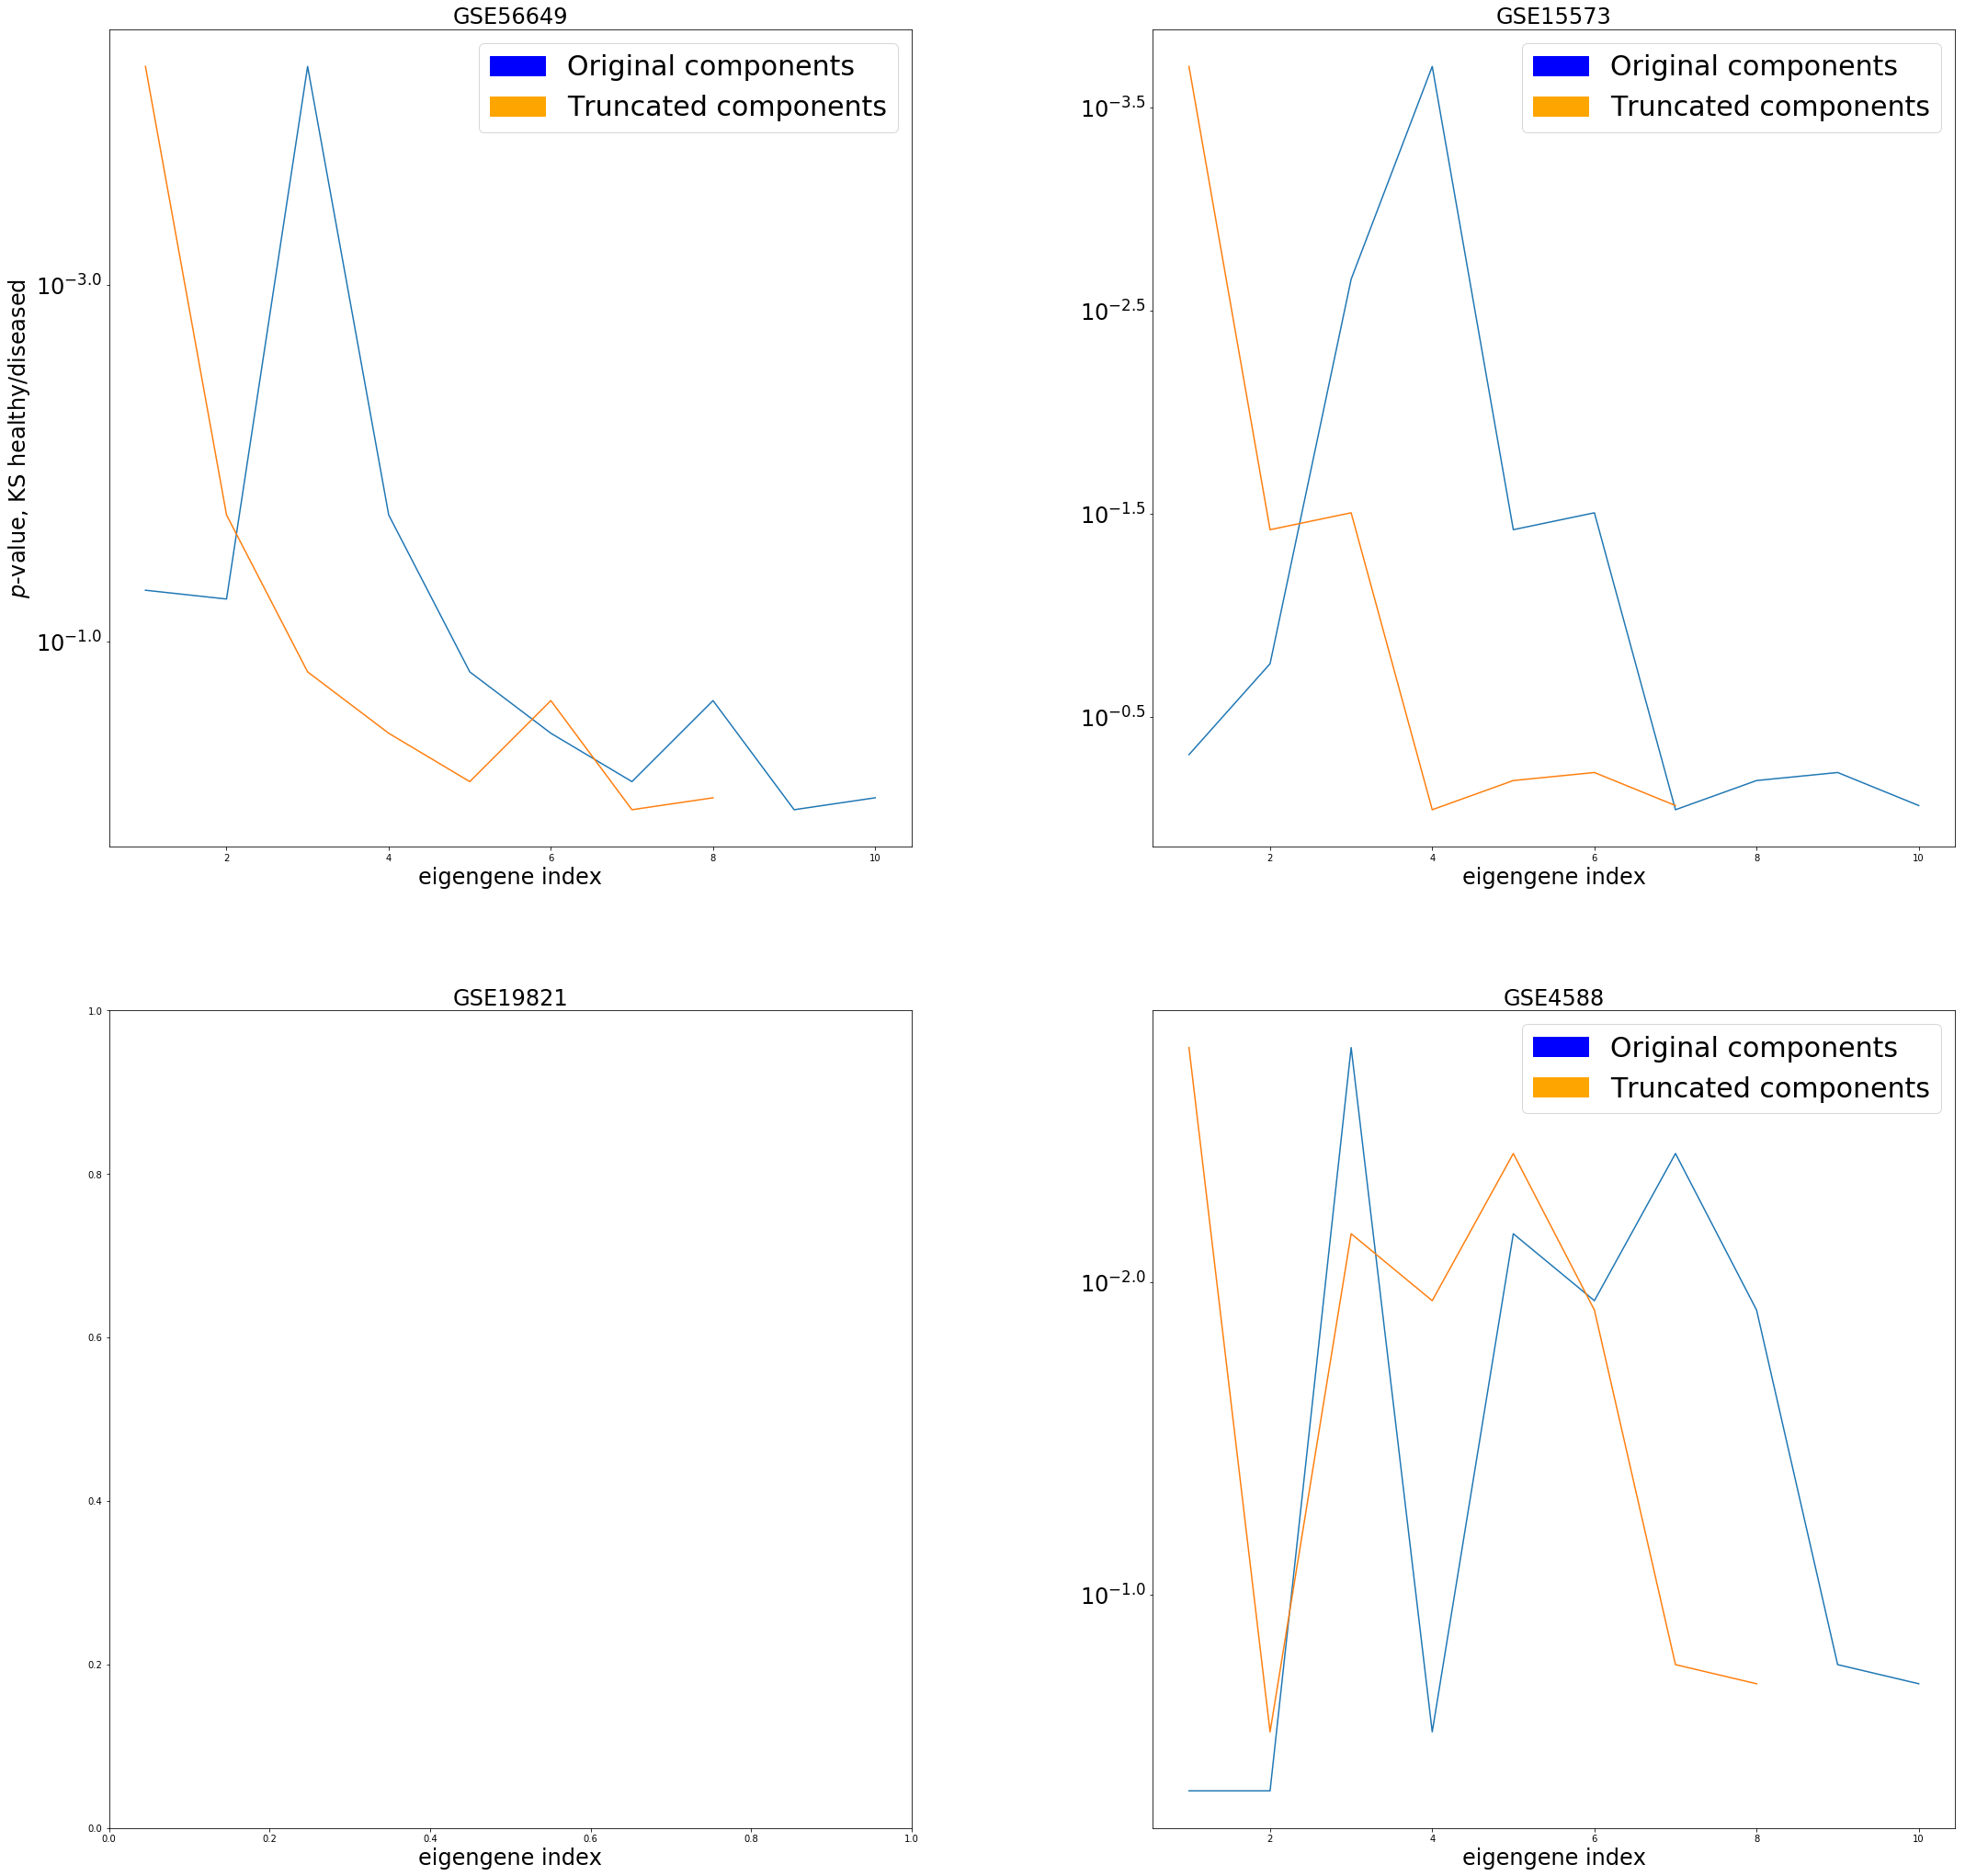

In [5]:
plt.figure(figsize=(36,36))

batches_df_without_first_components = []

for i,batch in enumerate(batches_df):
    # plot stuff
    plt.subplot(2,2,i+1)
    plt.title(list_of_dataset_to_load[i],size=24)
    plt.xlabel("eigengene index",size=24)
    if i==0: plt.ylabel("$p$-value, KS healthy/diseased", size=24)
        
    # call find_index_first_representative_component
    try:
        effect_strength, df_trans, model = find_index_first_representative_component(batch, method="SVD")
        effect_strength = effect_strength[1]
        # get max_val (l)
        max_val = (list(effect_strength).index(max(effect_strength)))
    except ValueError:
        print("WARNING:", "there are only a class of samples inside the batch, so we cannot compute the ks_2samp")
        continue
    
    # set 0 all l-1 columns
    df_trans.iloc[:,0:max_val] = 0
    #df_trans.iloc[:,max_val+1:] = 0
    
    # back to genes space
    batch_df_without_components_t = model.inverse_transform(df_trans)
    
    # convert from numpy to dataframe (rows are samples, columns are genes yet)
    batch_df_without_components_t = pd.DataFrame(data = batch_df_without_components_t,
                                                columns = batch.index,
                                                index = df_trans.index)
    
    # fill nan with zeros
    # batch_df_without_components_t = batch_df_without_components_t.fillna(value=0)
    
    # do the transpose and save it back again
    batches_df_without_first_components.append(batch_df_without_components_t.transpose())
    
    # plot stuff
    y = np.log10(effect_strength)
    plt.plot(range(1,y.shape[0]+1),y)
    yticks = plt.yticks()[0][::2]
    plt.yticks(yticks,["$10^{-%1.1f}$"%i for i in yticks],fontsize=24)
    plt.subplots_adjust(wspace=0.3)
    
    # plot again ignoring the first l-1 components
    # NOTES: theoretically, we have to call find_index_first_representative_component
    # and plot the results, the following is just to have a quick idea of effect
    y = np.log10(effect_strength[max_val:])
    plt.plot(range(1,y.shape[0]+1),y)
    
    blue_patch = mpatches.Patch(color='blue', label='Original components')
    orange_patch = mpatches.Patch(color='orange', label='Truncated components')
    plt.legend(handles=[blue_patch, orange_patch], prop={'size': 30})

In [6]:
print("One of the batch after intrinsic error removal")
batches_df_without_first_components[0].head()

One of the batch after intrinsic error removal


,GSM1366352_UD,GSM1366356_UD,GSM1366354_UD,GSM1366358_UD,GSM1366360_UD,GSM1366366_UN,GSM1366351_UD,GSM1366367_UN,GSM1366369_UN,GSM1366362_UN,...,GSM1366357_UD,GSM1366359_UD,GSM1366361_UN,GSM1366355_UD,GSM1366363_UN,GSM1366350_UD,GSM1366348_UD,GSM1366368_UN,GSM1366364_UN,GSM1366365_UN
ENTREZ_GENE_ID,,,,,,,,,,,,,,,,,,,,,
1,-0.181779,-0.150961,-0.039975,0.142814,0.272095,0.083704,0.107688,-0.097732,0.117934,0.017056,...,0.009456,0.019796,0.165831,0.147957,-0.002351,-0.490991,-0.224957,-0.072430,0.196490,0.128403
10,-0.062380,-0.299082,-0.072459,1.122226,0.132067,-0.082041,0.134431,-0.317764,0.005418,-0.230666,...,-0.528314,-0.022056,0.063371,-0.332057,-0.310403,0.620700,0.393909,-0.192403,0.880473,-0.173818
100,0.152238,0.173781,-0.378895,-0.599487,-1.059834,0.020207,-0.067227,0.270849,-0.017127,0.014741,...,0.601030,-0.367278,-0.145728,0.383403,0.207386,0.395393,-0.039288,0.313358,-0.035047,-0.057204
1000,-0.251661,-0.345029,-0.285571,0.533893,-0.130066,0.150636,0.354327,-0.669650,0.340333,0.292399,...,0.242922,0.207980,0.384265,0.019197,-0.321383,-0.505081,-0.198939,-0.416315,0.318091,0.182642
10000,0.234458,0.308372,0.173519,-0.025266,0.019050,-0.177648,-0.098165,-0.001852,-0.326444,-0.378662,...,0.364844,0.261812,-0.334172,0.115570,-0.209602,0.167500,0.104865,-0.079282,-0.226932,-0.237708


Shape after concatenation: (27745, 89)
Shape after rows with na: (17285, 89)


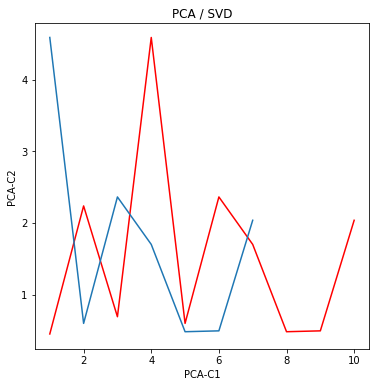

In [7]:
# merge new batches after intrinsic error removal
merged_df_without_first_components = pd.concat(batches_df_without_first_components, axis='columns')
print("Shape after concatenation:", merged_df_without_first_components.shape)
merged_df_without_first_components = merged_df_without_first_components.dropna(axis='rows', how='any')
print("Shape after rows with na:", merged_df_without_first_components.shape)

# apply again svd to notice the batch effect
effect_strength, df_trans, model = find_index_first_representative_component(merged_df_without_first_components, method="SVD")

plt.figure(figsize=[6,6])
plt.plot(range(1, 11), np.log10(effect_strength[1]), c='red')
plt.ylabel('PCA-C2')
plt.xlabel('PCA-C1')
plt.title("PCA / SVD")

# === Remove batch effect ===
effect_strength = effect_strength[1]

# get max_val (l)
max_val = (list(effect_strength).index(max(effect_strength)))

# set all componenet except the most contributive to zero
df_trans.iloc[:,0:max_val] = 0
#df_trans.iloc[:,max_val+1:] = 0

# plot again ignoring the first l-1 components
# NOTES: theoretically, we have to call find_index_first_representative_component
# and plot the results, the following is just to have a quick idea of effect
y = np.log10(effect_strength[max_val:])
plt.plot(range(1,y.shape[0]+1),y)
plt.show()

# back to genes space
batch_df_without_components_t = model.inverse_transform(df_trans)

# convert from numpy to dataframe (rows are samples, columns are genes yet)
batch_df_without_components_t = pd.DataFrame(data = batch_df_without_components_t,
                                                    columns = merged_df_without_first_components.index,
                                                    index = df_trans.index)

# do the transpose and save it back again
merged_df_no_batch_effect = batch_df_without_components_t.transpose()

In [8]:
print("Merged batches after batch effect removal")
merged_df_no_batch_effect.head()

Merged batches after batch effect removal


,GSM1366352_UD,GSM1366356_UD,GSM1366354_UD,GSM1366358_UD,GSM1366360_UD,GSM1366366_UN,GSM1366351_UD,GSM1366367_UN,GSM1366369_UN,GSM1366362_UN,...,GSM101872_UN,GSM102706_UD,GSM101877_UN,GSM101885_UD,GSM101882_UD,GSM101966_UN,GSM102709_UD,GSM101964_UN,GSM101970_UN,GSM102704_UD
1,-0.155361,-0.110958,0.069137,0.029201,0.197766,0.045528,-0.019298,0.017040,0.093582,0.117321,...,-0.150601,-0.302289,-0.542854,-0.112787,-0.174295,0.363509,-0.068755,-1.306444,-0.006408,-0.078541
10,-0.173742,-0.115917,0.159033,0.209071,0.441111,0.010152,0.017363,-0.054263,0.013753,-0.088137,...,-0.129817,-0.183581,1.011912,-0.117203,-0.146117,0.205028,-0.107710,-0.420291,0.070933,-0.209005
100,0.257657,0.157186,-0.379061,-0.283582,-0.932826,0.003356,0.028188,-0.014975,0.029576,0.201698,...,-0.150895,0.137648,-0.068094,0.151724,0.008442,-0.019112,0.032720,-0.432232,0.029842,0.077881
1000,0.200891,0.198900,0.027286,0.125313,-0.097238,-0.109392,0.058648,-0.203116,-0.184793,-0.147824,...,-0.717785,0.182463,-0.483945,0.307122,0.196304,0.213111,0.102527,0.972360,-0.090301,0.020631
10000,0.078426,0.049537,0.009761,0.048469,0.016822,-0.035847,-0.005627,0.008212,-0.064376,-0.087370,...,0.176774,0.123376,0.158345,-0.067074,-0.003573,-0.085943,0.085794,-0.107867,0.092873,0.118362


In [9]:
# Because we are interested in collapse the dimension of the sample and not the one of the genes
merged_df_t = merged_df_no_batch_effect.transpose()

# apply a Standardization first
merged_df_std = StandardScaler().fit_transform(merged_df_t)

# define the PCA object, using 3 components
pca = PCA(n_components=3, svd_solver="full", whiten=True)

# apply the PCA on our dataset
pca_trans = pca.fit_transform(merged_df_std)
print('variance_ratio', pca.explained_variance_ratio_)
print('variance', pca.explained_variance_)

# create a dataframe from pca results
pca_trans_df = pd.DataFrame(data=pca_trans, index=merged_df_t.index)

# plot pca results with respect to the batch
batch_color = []
dict_of_colors = {}

list_of_colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', 'w']
person_batch_index=[x for x in person_batch_index if x != 2]
color_per_sample = [list_of_colors[x] for x in person_batch_index]


fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
blue_patch = mpatches.Patch(color='blue', label='GSE2508')
green_patch = mpatches.Patch(color='green', label='GSE26637')
red_patch = mpatches.Patch(color='red', label='GSE27949')
yellow_patch = mpatches.Patch(color='yellow', label='GSE48964')
ax.scatter(pca_trans_df[0], pca_trans_df[1], pca_trans_df[2], c=color_per_sample)
ax.set_xlabel('X: PCA-C1')
ax.set_ylabel('Y: PCA-C2')
ax.set_zlabel('Z: PCA-C3')
plt.title("PCA plot respect to batch")
plt.legend(handles=[blue_patch, green_patch, red_patch, yellow_patch])
plt.savefig(plot_dir_path + 'PCA_merged_std.pdf', format="pdf")
plt.close(fig)
print("-> Created 3D plot in ./plot/PCA_merged_std.pdf")

variance_ratio [ 0.24188432  0.186002    0.12668156]
variance [ 4228.48158421  3251.57922738  2214.57364585]
-> Created 3D plot in ./plot/PCA_merged_std.pdf


In [11]:
import pickle

data_dir_path = './data/'
if not os.path.exists(plot_dir_path):
    os.makedirs(plot_dir_path)
    print('created ./path directory')

file_path = data_dir_path + 'merged_df_no_batch_effect_project.pkl'
merged_df_no_batch_effect.to_pickle(file_path)
print("Saved into", file_path)

Saved into ./data/merged_df_no_batch_effect_project.pkl
